Task

* Business Understanding
* Data understanding
* Exploratory data Analysis
* Data Preparation
* Model Building ( Logistic Regression, ensemble, Boosting etc)
* Model Selection
* Performance reporting
* Deploy the model
* Converting ML metrics into Business metric and explaining result to business
* Prepare presentation for non technical persons.

* Data Set Information :

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

Attribute Information:

Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [21]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score,precision_recall_curve,precision_score,recall_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
df = pd.read_csv('bank-full.csv',sep = ';')


In [23]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [24]:
df.shape

(45211, 17)

In [25]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [26]:

from sklearn import preprocessing

count = 0

for col in df:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:     
            le = preprocessing.LabelEncoder()
            df[col] = le.fit_transform(df[col])
            count += 1
            print (col)
            
print('%d columns were label encoded.' % count,'shape = ',df.shape)

default
housing
loan
y
4 columns were label encoded. shape =  (45211, 17)


In [27]:
df = pd.get_dummies(df)
print(df.shape)

(45211, 49)


In [28]:
X=df.drop("y",axis=1)
y=df[["y"]]

In [29]:
X.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,261,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
1,44,0,29,1,0,5,151,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
2,33,0,2,1,1,5,76,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
3,47,0,1506,1,0,5,92,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
4,33,0,1,0,0,5,198,1,-1,0,...,0,0,1,0,0,0,0,0,0,1


## Dealing with imbalance

In [30]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [31]:
X=df.drop("y",axis=1)
y=df[["y"]]

In [32]:
smt = SMOTE()
X,y = smt.fit_resample(X,y)

In [33]:
y.value_counts()

y
0    39922
1    39922
dtype: int64

## Model building

In [34]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
nb = GaussianNB()
svc = SVC(probability=True)

In [35]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [37]:

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [38]:
log_reg = LogisticRegression(C = 0.0001,random_state=21)
log_reg.fit(X_train, y_train)

C:\Users\babla\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(C=0.0001, random_state=21)

In [39]:
print_score(log_reg, X_train, y_train, X_test, y_test, train=False)

Test Result:

accuracy score: 0.9370

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      7985
           1       0.97      0.90      0.93      7984

    accuracy                           0.94     15969
   macro avg       0.94      0.94      0.94     15969
weighted avg       0.94      0.94      0.94     15969


Confusion Matrix: 
 [[7752  233]
 [ 773 7211]]



In [40]:
from xgboost import XGBClassifier
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_test, y_test, train=False)

C:\Users\babla\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\babla\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[11:15:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test Result:

accuracy score: 0.9488

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.95      0.95      7985
           1       0.95      0.94      0.95      7984

    accuracy                           0.95     15969
   macro avg       0.95      0.95      0.95     15969
weighted avg       0.95      0.95      0.95     15969


Confusion Matrix: 
 [[7622  363]
 [ 455 7529]]



Text(0.5, 1.0, ' Xg boost Feature Importance')

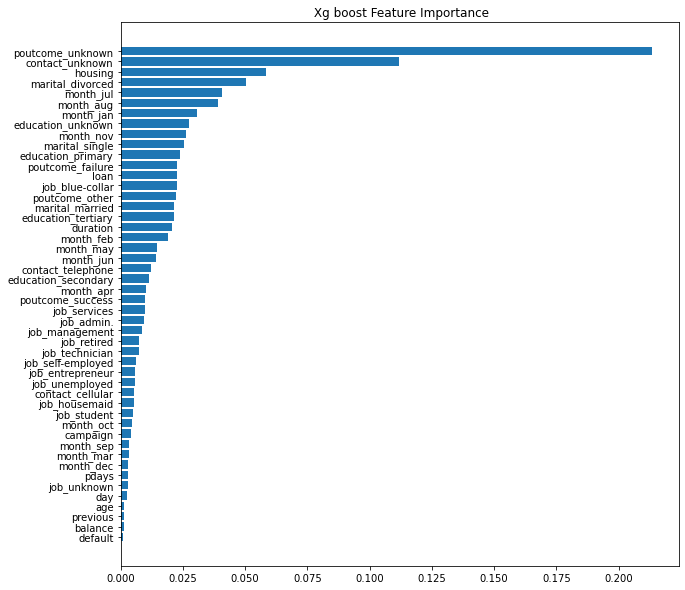

In [56]:
plt.figure(figsize=(10, 10))
sorted_idx = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.title(" Xg boost Feature Importance")


In [41]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print_score(dt, X_train, y_train, X_test, y_test, train=False)

Test Result:

accuracy score: 0.9244

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.92      0.92      7985
           1       0.92      0.93      0.92      7984

    accuracy                           0.92     15969
   macro avg       0.92      0.92      0.92     15969
weighted avg       0.92      0.92      0.92     15969


Confusion Matrix: 
 [[7323  662]
 [ 545 7439]]



In [42]:
clf_rf = RandomForestClassifier(n_estimators=40, random_state=21)
clf_rf.fit(X_train, y_train)

<ipython-input-42-f977b848e95d>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=40, random_state=21)

In [47]:
print_score(clf_rf, X_train, y_train, X_test, y_test, train=False)

Test Result:

accuracy score: 0.9473

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      7985
           1       0.96      0.93      0.95      7984

    accuracy                           0.95     15969
   macro avg       0.95      0.95      0.95     15969
weighted avg       0.95      0.95      0.95     15969


Confusion Matrix: 
 [[7669  316]
 [ 526 7458]]



In [45]:
clf_rf.feature_importances_

array([0.03306372, 0.0007155 , 0.03744446, 0.06759941, 0.02080228,
       0.03762348, 0.21597628, 0.02328755, 0.02351633, 0.01318287,
       0.00886578, 0.02460077, 0.00357643, 0.00257576, 0.0168036 ,
       0.00306953, 0.00386063, 0.00895059, 0.00235066, 0.01724277,
       0.00318292, 0.00066838, 0.01731633, 0.03484293, 0.02102709,
       0.02011838, 0.0296071 , 0.02055839, 0.00597537, 0.00910748,
       0.00685687, 0.05988032, 0.00853292, 0.03358898, 0.00100568,
       0.0113397 , 0.00938982, 0.03120649, 0.01143185, 0.00203996,
       0.0395251 , 0.02030276, 0.00290483, 0.00185578, 0.01124384,
       0.00471559, 0.00827119, 0.00839553])

Text(0.5, 1.0, 'Random Forest Feature Importance')

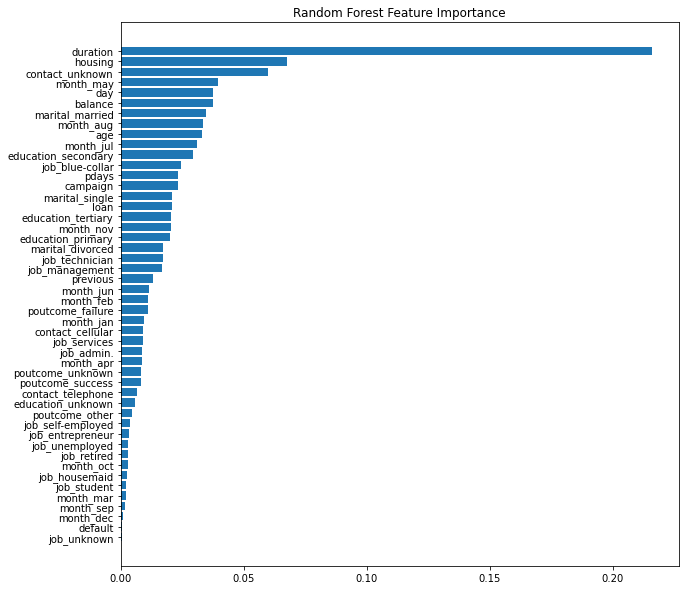

In [55]:
plt.figure(figsize=(10, 10))
sorted_idx = clf_rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], clf_rf.feature_importances_[sorted_idx])
plt.title("Random Forest Feature Importance")


In [52]:
import gc
gc.collect()

37

In [48]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier

In [49]:
def kfold_lightgbm(train_df, num_folds, stratified = False):
    print("Starting LightGBM. Train shape: {}".format(train_df.shape))
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)

    oof_preds = np.zeros(train_df.shape[0])

    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['y']]
    
      # Splitting the training set into folds for Cross Validation
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['y'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['y'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['y'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=32,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1,
            )
         # Fitting the model and evaluating by AUC
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 200)
        print_score(clf, train_x, train_y, valid_x, valid_y, train=False)
        # Dataframe holding the different features and their importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        # Freeing up memory
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    display_importances(feature_importance_df)
    return feature_importance_df

In [50]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(15, 12))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

Starting LightGBM. Train shape: (45211, 49)
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[722]	training's auc: 0.949372	training's binary_logloss: 0.178298	valid_1's auc: 0.930503	valid_1's binary_logloss: 0.201088
Test Result:

accuracy score: 0.9068

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.96      0.95     13325
           1       0.63      0.46      0.54      1746

    accuracy                           0.91     15071
   macro avg       0.78      0.71      0.74     15071
weighted avg       0.90      0.91      0.90     15071


Confusion Matrix: 
 [[12857   468]
 [  937   809]]

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[1

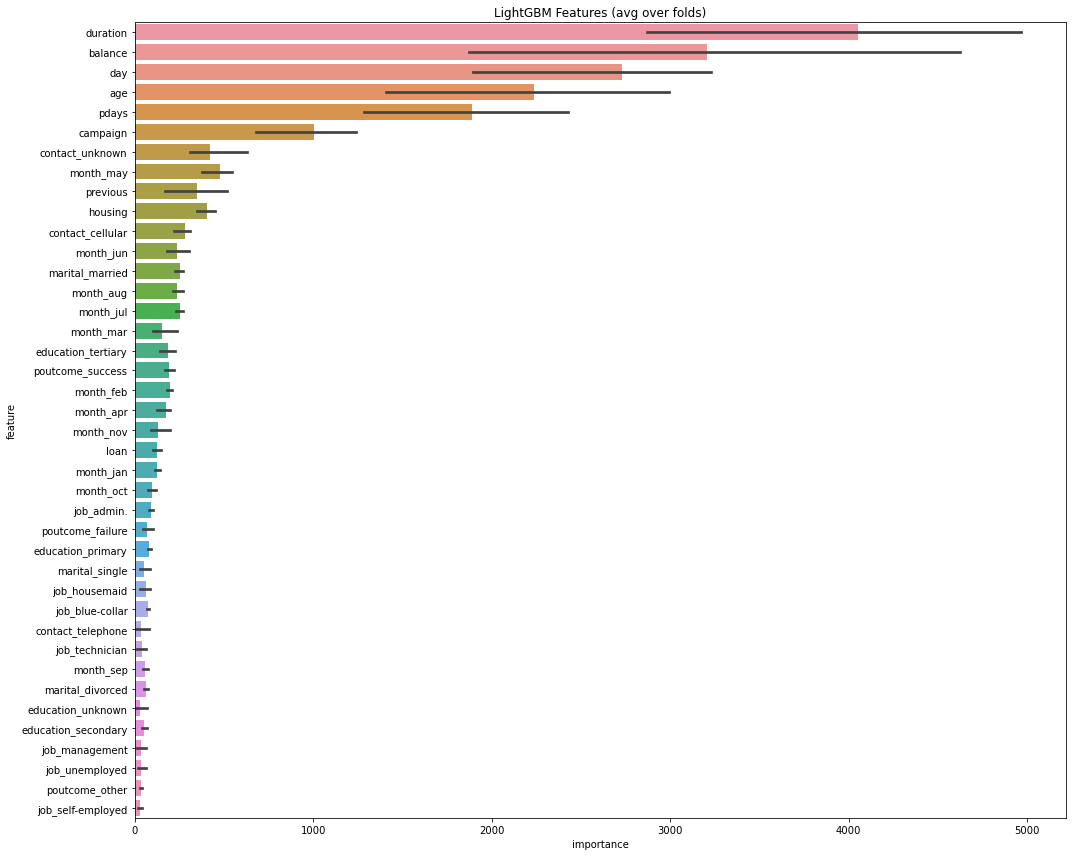

In [57]:
feat_importance = kfold_lightgbm(df, num_folds= 3, stratified= False)